In [17]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [18]:
path = 'opencv_filtered-20220427-183533'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [19]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [20]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-27 18:35:33.831913,9.0,3647946752
1,2022-04-27 18:35:44.896916,51.1,3015847936
2,2022-04-27 18:35:55.899913,57.1,3022073856
3,2022-04-27 18:36:07.051414,49.7,3019530240
4,2022-04-27 18:36:18.479914,53.5,2992148480
5,2022-04-27 18:36:29.570414,51.1,3043168256
6,2022-04-27 18:36:40.628413,57.8,3203141632
7,2022-04-27 18:36:51.943413,52.5,3178864640
8,2022-04-27 18:37:03.013913,57.5,3178934272
9,2022-04-27 18:37:14.033913,56.4,3019390976


In [21]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

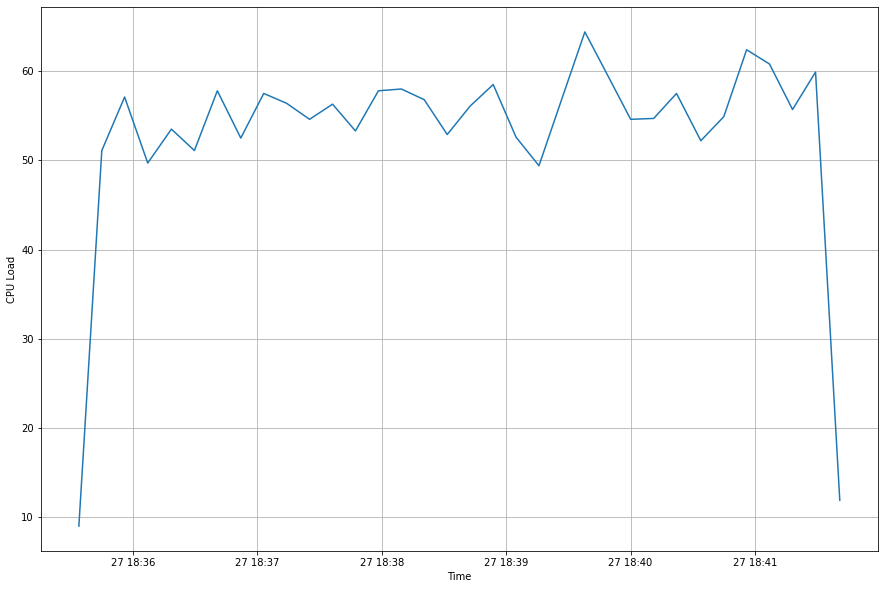

In [22]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

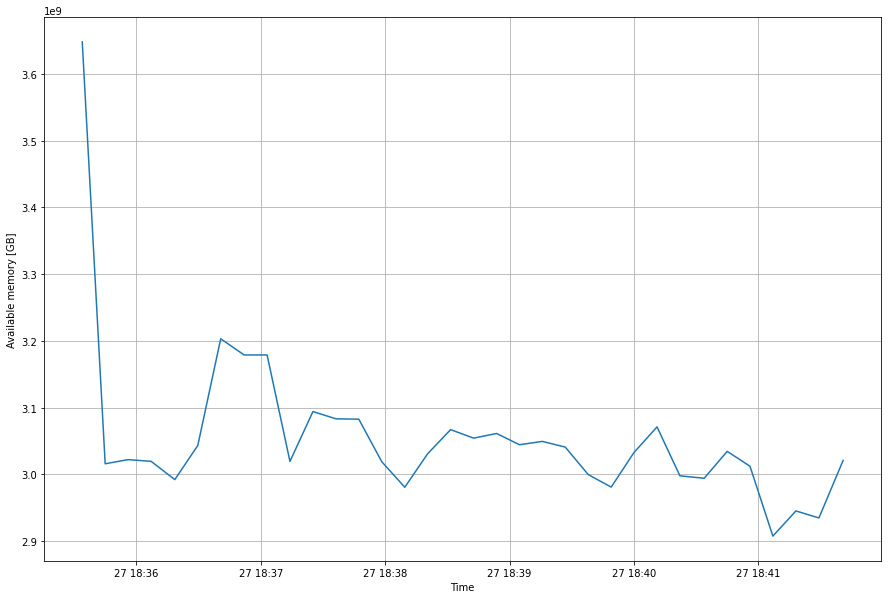

In [23]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

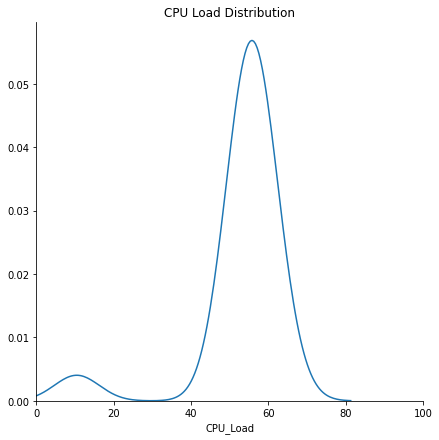

In [24]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

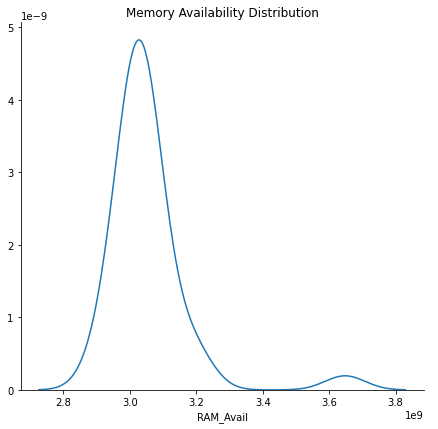

In [25]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [26]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-27 18:35:34.614413,231010100,0.75,0.375000,0.500000,"[0.6699566160520607, 0.7114774889029803, 0.044...",3,1,5,8,"[(770.0, 196.0, 857.0, 283.0), (298.0, 156.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-27 18:35:34.708913,88135000,0.00,0.000000,0.000000,[0.0],0,1,1,1,"[(417.0, 714.0, 737.0, 1034.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-27 18:35:34.802913,84012800,0.00,0.000000,0.000000,[],0,0,1,2,"[(449.0, 40.0, 502.0, 93.0), (684.0, 322.0, 78...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-27 18:35:35.002914,91608000,0.00,0.000000,0.000000,[],0,0,0,62,[],"[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-27 18:35:35.085413,63447500,0.80,0.571429,0.666667,"[0.07943482963764197, 0.6260277856535299, 0.65...",4,1,3,8,"[(720.0, 63.0, 767.0, 110.0), (172.0, 6.0, 344...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-27 18:41:30.468413,149015500,1.00,1.000000,1.000000,[0.6655021834061136],1,0,0,1,"[(460.0, 153.0, 622.0, 315.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-27 18:41:30.618414,141746600,1.00,0.500000,0.666667,[0.6259521218715995],1,0,1,2,"[(690.0, 412.0, 808.0, 530.0)]","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-27 18:41:30.775412,87546600,0.00,0.000000,0.000000,[],0,0,0,27,"[(541.0, 379.0, 581.0, 419.0), (573.0, 319.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-27 18:41:30.839413,48565900,0.00,0.000000,0.000000,[],0,0,2,7,"[(290.0, 199.0, 393.0, 302.0)]","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [27]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,8.149369e+07,0.423904,0.400538,0.380796,1.086175,0.456913,1.122133,12.308741
std,3.305176e+07,0.450318,0.439428,0.407100,1.876831,0.916771,2.098348,39.822258
min,1.809680e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.995248e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.573230e+07,0.250000,0.200000,0.285714,1.000000,0.000000,1.000000,3.000000
75%,9.418060e+07,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,9.000000
max,4.696282e+08,1.000000,1.000000,1.000000,24.000000,8.000000,33.000000,709.000000


In [28]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,167,True,True,False
1,163,True,True,False
2,157,True,True,False
3,155,True,True,True
4,150,True,True,True
...,...,...,...,...
4973,6,False,False,False
4974,6,True,True,False
4975,6,False,False,False
4976,6,True,True,False


In [29]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [30]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,167,True,True,False,1.000000,0.000140,1.000000,0.000140,0.000000,0.000000
1,163,True,True,False,1.000000,0.000281,1.000000,0.000281,0.000000,0.000000
2,157,True,True,False,1.000000,0.000421,1.000000,0.000421,0.000000,0.000000
3,155,True,True,True,1.000000,0.000561,1.000000,0.000561,0.250000,0.000140
4,150,True,True,True,1.000000,0.000702,1.000000,0.000702,0.400000,0.000281
...,...,...,...,...,...,...,...,...,...,...
4973,6,False,False,False,0.706876,0.493543,0.681544,0.475856,0.163450,0.114121
4974,6,True,True,False,0.706935,0.493683,0.681608,0.475997,0.163417,0.114121
4975,6,False,False,False,0.706793,0.493683,0.681471,0.475997,0.163384,0.114121
4976,6,True,True,False,0.706852,0.493824,0.681535,0.476137,0.163351,0.114121


In [31]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

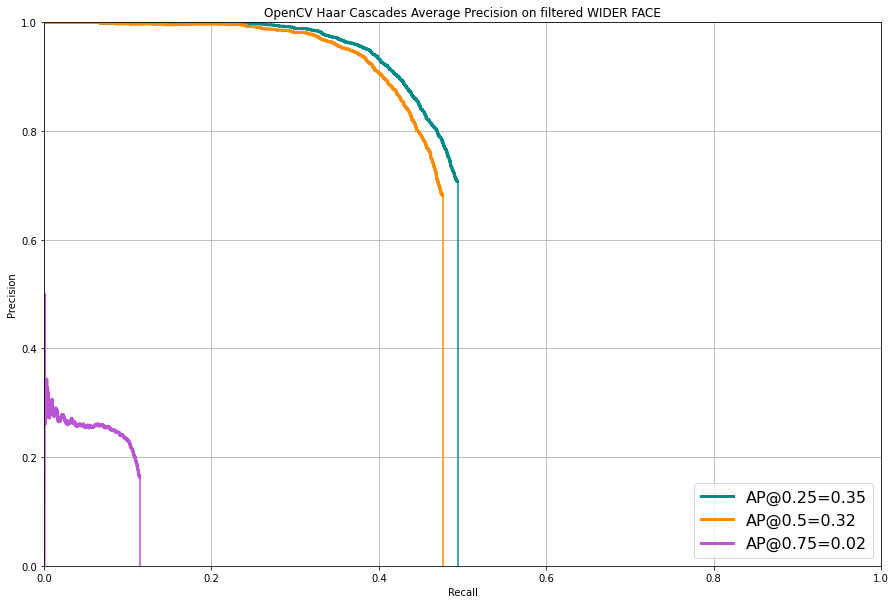

In [32]:
plot_pr(df_ap, 'OpenCV Haar Cascades Average Precision on filtered WIDER FACE')